## **MIDTERM PROJECT -** 
###For Advanced Process Safety with the guidance of Dr. Tianxing Cai

###Combining HAZOP with dynamic simulation—Applications for safety


###Oxidation of 2-octanol in a semi-batch reactor

Preparation and validation of the simulation model as per the [research idea](http://www.sciencedirect.com/science/article/pii/S0950423006000428/)


The below is the python routine to solve the system of First-Order Oridinary Differential Equation using `scipy.optimize.odeint` module

In [29]:
#Importing the required library:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import seaborn as sns; sns.set() 

%matplotlib inline

np.random.seed(211) 

#Input Data

maA1 = 10**5 # Pre-exponential factor reaction 1 [m3/kmol/s]
mpA2 = 10**10 # Pre-exponential factor reaction 2[m3/kmol/s]
E1perR = 11300 # Activation temperature reaction 1 [K]
E2perR = 12000 # Activation tempetature reaction 2 [K]
m1 = 6.6 # Hammett's reaction rate coeff. reaction 1
m2 = 2.2 # Hammett's reaction rate coeff. reaction 2
RhoOctan = 820.7 # Density of 2-octanol [kg/m3]
MwOctan = 130.23 # Molar mass of 2-octanol [kg/kmol]
Mw = 63 # Molar mass of HNO3 [kg/kmol]
RhoAcid = 1500 # Density of pure nitric acid [kg/m3]
RhoCPdos = 2 * 10 ** 6 # Heat capacity of dose [J/m3/K]
Tdos = 293.15 # Temperature of feed dose [K]
Hnol = 160 * 10 ** 6 # Specific heat of reaction 1 [J/kmol]
Hnone = 520 * 10 ** 6 # Specific heat of reaction 2 [J/kmole]
RhoCoolant = 1000 # The density of coolant [kg/m3]
CpCoolant = 4183 # Heat capacity of coolant [J/kg/K]
Vj = 1.5 # Volume of the jacket [m3]


#Initial Data

#t_0 = 0.0001 # Starting time
#Np_0 = 0 # Number of moles of 2-octanone (P) at t = t0
#Nx_0 = 0 # Number of moles of carboxylic acids (X) at t = t0
Vr0 = 1.5 # Initial volume in a reactor [m3]
Y = 0.035 # Initial concentr. of nitrosonium ion Y=Nb0/NaF
Percent = 0.6 # Initial mass concentr of nitr. acid sol. [%]
#Tr_0 = 260 # Temp. in the reactor at t = t0 (K)
Gamma0 = 5.4 * 10 ** 6 # Initial heat capacity of the system [J/K]
UA0 = 1500 # Initial cool. surface heat trans. coeff.[W/K]
#Tcool_0 = 273.15 # Coolant exit temp. at t = t0 (K)
Tcool_IN = 260 # Initial coolant temperature [K]

#Final Data

tf = 72000 # Final time (s)
Vdos1 = 0.6 # Final volume of the dose [m3]
tdos = 36000 # dosing time [s], 10h
UA1 = 2100 # Final cool. surface heat trans. coeff. [W/K]

# Equations

def Mymodel(y,t):
    NnO = Vr0 * Percent * RhoAcid / float(Mw) # Initial number of mole of HNO3 [kmole]
    wt = NnO * Mw / float(Vr0 * RhoAcid) # Mass concentr. of nitric acid sol [%/100%]
    H = -0.6221 - 3.7214 * wt - 1.5714 * wt ** 2 # Hammett's acidity function
    Epsd = Vdos1/float(Vdos1+Vr0) # Volume fraction of dispersed phase
    NaF = (Vdos1 * RhoOctan) / float(MwOctan) # Total amount of 2-octanol (a) fed [kmol]
    tdos = 3600
    if t in range(0,3600):
        Theta = t / float(tdos)
    else:
        Theta=1  # Dimensionless time up to t=tdos
    CaOrg = (Theta * NaF - y[0] - y[1]) / float(Vdos1 * Theta) # Concentr of a in org phase [kmole/m3]
    CpOrg = y[0] / float(Vdos1 * Theta) # Concentr. of (P) in org phase [kmol/m3]
    CbAq = (y[0] + Y * NaF) /float(Vr0) # Concentr. of (B) in aq. phase [kmole/m3]
    Fw = 100 / 60 * 10 ^ (-3) # flowrate 
    NaF = (Vdos1 * RhoOctan) / float(MwOctan) # Total amount of 2-octanol (a) fed [kmol]
    CnAq = (NnO - Y * NaF - y[0] - 2 * y[1]) / float(Vr0) # Concentr. of HNO3 in the aq. phase [kmol/m3]
    k1 = (maA1)*(math.e)**(-E1perR /float( y[2] - (m1*H))) # Specific reaction rate 1
    k2 = (mpA2)*(math.e)**(-E2perR /float(y[2] - (m2*H))) # Specific reaction rate 2 
    r1 = k1*CaOrg*CbAq*(1-Epsd) # Reaction rate of a and b to p[kmol/m3/s]
    r2 = k2*CpOrg*CbAq*(1-Epsd) # Reaction rate of p and b to x[kmol/m3/s]
    dy0 = (r1-r2)*Vr0/(float(1-Epsd))
    dy1 = (r1 * Vr0 / float(1 -Epsd))
    Phi = Vdos1 / tdos # Volumetric flow rate of the feed [m3/s]
    Qdos = Phi * RhoCPdos * (Tdos - y[2]) # Heat input due to reactant addition [W]
    UAcool = UA0 + (UA1 - UA0) * Theta # Cooling surface heat transfer coefficient [W/K]
    Qcool = UAcool * (y[3] - y[2]) # Heat removed by the cooling jacket [W]
    Gamma = Gamma0 + RhoCPdos * Phi * t # Total heat capacity of the system [J/K]
    Qnol = r1 * Vr0 * Hnol / float(1 - Epsd) # Heat of reaction, 1  [W]
    Qnone = r2 * Vr0 * Hnone / float(1 - Epsd) # Heat of reaction, 2 [W]
    Qr = Qnol + Qnone # Sum of the heat of reaction the reactions [W)
    dy2 = (Qr + Qdos + Qcool) / float(Gamma)  #Reactor energy balance (Tr in K)
    dy3 = (Fw * (Tcool_IN - y[3]) - Qcool / float(RhoCoolant * CpCoolant)) / float(Vj)  #Jacket energy balance (T in K)
    return[dy0, dy1, dy2, dy3]


In [30]:
def main():
    # initial values of y0,y1,y2,y3 at t=0
    yinit = [0.0,0.0,260,273.15]
    # Times at which the solution is to be computed.
    tf = 72000
    t = np.linspace(1, tf, 72000)
    yfinal = [3.1223447,0.2520688,261.64119,260.38278] 
    y = odeint(Mymodel, yinit , t)
    print 'Intial values of Np , Nx, Tr, Tcool are', yinit
    print 'Final values of Np , Nx, Tr, Tcool are ', yfinal
    plt.plot(t , y[:,1] )
    plt.xlabel('time(t)')
    plt.ylabel('moles')
    plt.title('Molar amounts of the desired and the undesired products in normal operating conditions')
    plt.xscale('log')
    plt.show()
    plt.plot(t , y[:,2] )
    plt.xlabel('time(t)')
    plt.ylabel('Reactor temperature in K')
    plt.title('Temperature variation in the reactor when the inlet temperature of the cooling media is increased to 265K')
    plt.xscale('log')

Intial values of Np , Nx, Tr, Tcool are [0.0, 0.0, 260, 273.15]
Final values of Np , Nx, Tr, Tcool are  [3.1223447, 0.2520688, 261.64119, 260.38278]


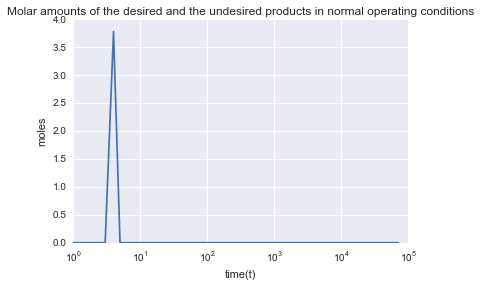

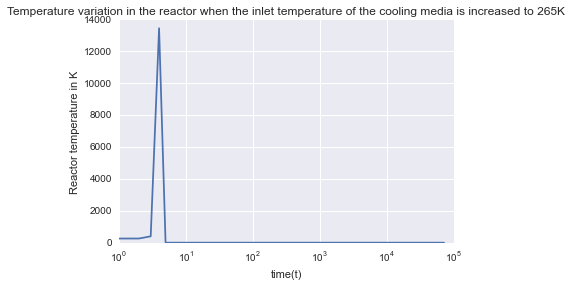

In [31]:
if __name__=="__main__":
    main()

### Oxidation of 2-octanol in a semi-batch reactor— quantitative HAZOP

###The Semi-batch reactor operation in normal operating conditions

|Variable                       |    initial value  |minimal value|   maximal value|   final value|
| ----------------------------------------------------------------------------------------------- |
| t(time, s)                    |   1.0E-04         |1.0E-04      |   7.2E+04      |   7.2E+04    |
| Np(2-octanone, mol)           |    0              |0            |  3.1223447     |3.1223447     |
| Nx(carboxylic acids, mol)     |    0              |0            |  0.2520688     |0.2520688     |
| Tr(reactor temperature, K)    |    260            |260          |  274.57096     |261.64119     |
| Tcool(cooling temperature, K) |    273.15         |260.38278    |  273.15        |260.38278     |


### Investigation of the effect of the reduction of the flow rate of the coolant for HAZOP

|Fw (l/min)                     |    600            |    300      |   200          |   100        |   70        |
| ------------------------------------------------------------------------------------------------------------- |
| Np (kmol)                     |   3.18            |    3.17     |   3.16         |   3.07       |      0.01   |
| Nx (kmol)                     |    0.21           |    0.23     |   0.26         |   0.36       |      3.78   |
| Treactor,max (C)              |    0.15           |    0.55     |   1.31         |   4.38       |      196    |
| Tcool,max (C)                 |   11.5            |    11.0     |   10.4         |   8.40       |      39     |

### Investigation of the effects of the reduction of the effective heat transfer rates for HAZOP
|Effective heat transfer rate   |    100%           |    90%      |   81%          |   80%        |   70%       |    60%      |
| --------------------------------------------------------------------------------------------------------------------------- | 
| Np (kmol)                     |    3.16           |    3.08     |   0.05         |   0.14       |      0.03   |      0.38   |
| Nx (kmol)                     |    0.26           |    0.33     |   3.71         |   3.3        |      2.63   |      2.64   |
| Treactor,max (C)              |    10.4           |    10.2     |   8.88         |   6.42       |      0.3    |      2.37   |
| Tcool,max (C)                 |    1.31           |    3.9      |   195          |   177        |      147    |      128    |

### Some deviations that may cause temperature runaway


|Guide word       | Deviation                        | Normal value           | Limit            |
| ---------------------------------------------------------------------------------------------- |
|None             | No flow in the cooling jacket    |                        |                  |
|Less of          |Lower coolant flow rate           |600 l/min               |Less than 70 l/min|
|Less of          |  Smaller heat transfer area      |100%                    |Less than 81%     |
|More of          | Higher coolant temperature       |-15                     | More than -6     |
|Less             | Shorter dosing time              | 20 h                   |Less than 7.5 h   |
|More of          | Larger dosing volume             |0.6m3                   |More than 0.81m3  |
|More of          | Higher nitric acid concentration |59%                     |More than 64%     |

###References

1. [Combining HAZOP with dynamic simulation—Applications for safety education](http://www.sciencedirect.com/science/article/pii/S0950423006000428/), by Shimon Eizenberg, Mordechai Shacham, Neima Brauner. 
2. [solving ODE in python](http://stackoverflow.com/questions/16909779/any-way-to-solve-a-system-of-coupled-differential-equations-in-python/)
3. [solving in python notebook](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/99f230e1104b46c1857417614de7e3bd/)
3. [using function numpy and linspace](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html)
3. [using function scipy](http://stackoverflow.com/questions/tagged/scipy)